In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elements.batteryModel import LithiumIonBattery, make_OCVfromSOCtemp, make_dOCVfromSOCtemp
from scipy.linalg import block_diag, cholesky
from copy import copy

In [2]:
udds = np.loadtxt("models/udds.txt")
udds

ik = np.hstack([np.zeros(300), udds[:,1], np.zeros(300), udds[:,1], np.zeros(241)])
t = np.arange(len(ik))/3600

Text(0, 0.5, 'Current (A)')

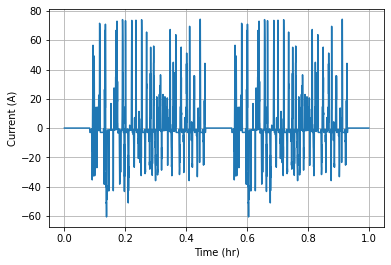

In [3]:
plt.plot(t, ik)
plt.grid()
plt.xlabel('Time (hr)')
plt.ylabel('Current (A)')

In [4]:
# battery cells
z0 = np.arange(0.9, 0.6, -0.1)       # set initial SOC for each cell in pack
R0 = np.arange(1.3, 1, -0.1)*1e-3    # set R0 for each cell in pack
Q0 = np.arange(25, 29, 1)            # set Q for each cell in pack

print(z0, R0, Q0)

cell1 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell2 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell3 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell4 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)

cell1.z_k, cell2.z_k, cell3.z_k, cell4.z_k = z0
cell1.R0Param, cell2.R0Param, cell3.R0Param, cell4.R0Param = R0
cell1.QParam, cell2.QParam, cell3.QParam, cell4.QParam = Q0

batteryPack = [cell1, cell2, cell3, cell4]


[0.9 0.8 0.7 0.6] [0.0013 0.0012 0.0011 0.001 ] [25 26 27 28]


Text(0.5, 1.0, 'SOC versus time for 4 cells')

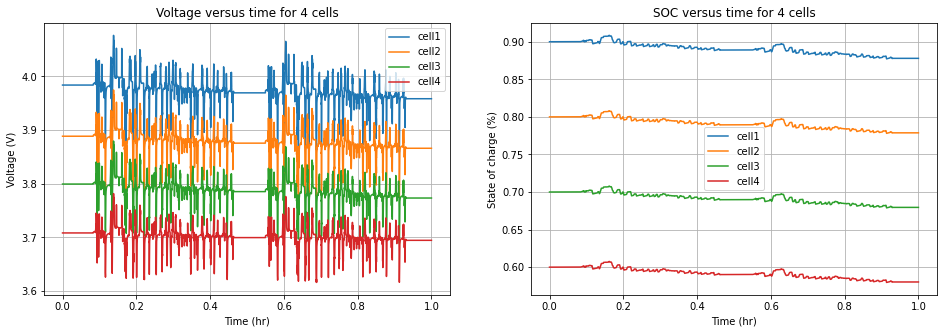

In [5]:
currents = np.zeros((len(t),1))
voltages = np.zeros((len(t),len(batteryPack)))
SOCs = np.zeros((len(t),len(batteryPack)))

for k,i in enumerate(ik):
    currents[k] = i
    
    for c,cell in enumerate(batteryPack):
        newState = cell.stateEqn(i)
        voltage = cell.outputEqn(i)
        cell.updateState(newState)

        voltages[k,c] = voltage
        SOCs[k,c] = cell.z_k.ravel()


plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(t, voltages)
plt.grid()
plt.legend(['cell1','cell2','cell3','cell4'])
plt.xlabel('Time (hr)')
plt.ylabel('Voltage (V)')
plt.title('Voltage versus time for 4 cells')

plt.subplot(1,2,2)
plt.plot(t, SOCs)
plt.grid()
plt.legend(['cell1','cell2','cell3','cell4'])
plt.xlabel('Time (hr)')
plt.ylabel('State of charge (%)')
plt.title('SOC versus time for 4 cells')


# Bar-Delta method

In [57]:
vk = voltages
ik = currents
zk = SOCs
T=25
z0, R0, Q0

ibias = 0.5
time = np.arange(len(ik))
deltat = 1

current = ik + ibias
voltage = vk
soc = zk

In [58]:
# Qinv = 1./Q0
# Qinvbar = np.mean(Qinv)
# dQinv = Qinv - Qinvbar
# Similarly, we will not estimate the delta-R0 values, but assume knowledge
dR0 = 0

# Reserve storage for computed results, for plotting
sochat = 0*time    # reserve storage for bar-soc values
socbound = sochat  # and bounds on those values
bias = sochat      # ... also for current-sensor bias estimate
biasBound = sochat # and bounds on that estimate

dsochat = np.zeros_like(voltage)   # reserve storage for delta-soc values
dsocbound = np.zeros_like(voltage) # and for bounds on those values
dR0 = np.zeros_like(voltage)        # reserve storage for delta-R0 values
dR0bound = np.zeros_like(voltage)   # and for bounds on those values

In [59]:
# Covariance values
# State ordering: ir,h,z,bias,R,Qinv
SigmaX0 = block_diag(1e2, 1e-4, 1e-2, 5e-2, 5e-2, 5e-2)  # uncertainty of initial state (ir,h,z,bias,R0,Qinv)
SigmaV  = block_diag(1e-3)                               # uncertainty of voltage sensor, output equation
SigmaW  = block_diag(1e-1, 1e-4, 1e-4, 1e-4)             # uncertainty of current sensor, bias, R0, Qinv

### init variables

In [60]:
LIB1 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)

# store model
model = copy(LIB1)
ir0   = 0                        
hk0   = 0                        
SOC0  = np.mean(soc[0])

xhat  = np.vstack([ir0,hk0,SOC0,0,0,0]) # initial state

# Covariance values
SigmaX = SigmaX0
SigmaV = SigmaV
SigmaW = SigmaW

# SPKF specific parameters
Nx = SigmaX0.shape[0]
Nw = 4
Nv = 1
Na = Nx+Nw+Nv

Wmx = np.zeros(2*Na+1)
h = np.sqrt(3)
Wmx[0] = (h**2-Na)/(h**2)
Wmx[1:] = 1/(2*h**2) 
Wcx=Wmx
Wm = Wmx.reshape(-1,1) # mean
Wc = Wcx.reshape(-1,1) # covar
Qbump = 5

# previous value of current
priorI = 0
signIk = 0

In [61]:
# Now, initialize variables for the "delta" filters
# SOC is estimated using SPKF
dNx = 1             # one state per delta filter, for estimating SOC
dNw = 1             # one process-noise per delta filter
dNa = dNx+dNw+Nv    # augmented length for delta filters

dWmx = np.zeros(2*dNa+1)
dh = h 
dWmx[0] = (h**2-dNa)/(h**2)                 # weighting factors when computing mean
dWmx[1:] = 1/(2*h**2)                       # and covariance
dWcx=dWmx                       
dWm = dWmx.reshape(-1,1)                    # mean
dWc = dWcx.reshape(-1,1)                    # covar

NUM_CELL = 4
celldz = np.zeros(NUM_CELL)
cellSdz = SigmaX0[2,2]*np.ones(NUM_CELL)

celldR0 = np.zeros(NUM_CELL)
cellSdR0 = SigmaX0[3,3]*np.ones(NUM_CELL)

celldQinv = np.zeros(NUM_CELL)
cellSdQinv = SigmaX0[-1,-1]*np.ones(NUM_CELL)

In [62]:
from mat4py import loadmat
data = loadmat('models/PANmodel.mat')

name = data['model']['name']
temps = data['model']['temps']
etaParam = data['model']['etaParam'][temps.index(25)]
QParam = data['model']['QParam'][temps.index(25)]
GParam = data['model']['GParam'][temps.index(25)]
M0Param = data['model']['M0Param'][temps.index(25)]
MParam = data['model']['MParam'][temps.index(25)]
R0Param = data['model']['R0Param'][temps.index(25)]
RCParam = np.array(data['model']['RCParam'][temps.index(25)])
RParam = np.array(data['model']['RParam'][temps.index(25)])

In [63]:
# Calculate new states for all of the old state vectors in xold.
def stateEqn(current, xnoise=0, oldState=None):
    dt = 1
    if oldState is not None: 
        (iR_k, h_k, z_k, ib_k, R0_k, Qinv_k) = oldState
        iR_k = iR_k.reshape(1,-1)
        h_k =  h_k.reshape(1,-1)
        z_k =  z_k.reshape(1,-1)
        ib_k =  ib_k.reshape(1,-1)
        R0_k =  R0_k.reshape(1,-1)
        Qinv_k =  Qinv_k.reshape(1,-1)
        
    # if abs(current)>1/(100*Qinv_k): sik = np.sign(current)
    sik = 0
    current = current - ib_k
    current = np.where(current<0, current*etaParam, current)
    current = current + xnoise[0,:]
    
    Ah = np.exp(-abs(current*GParam*dt*Qinv_k/3600))  # hysteresis factor
    Arc = np.diag(np.exp(-dt/abs(RCParam)))
    Brc = 1-(np.exp(-dt/abs(RCParam)))

    iR_k1 = Arc@iR_k + Brc*current
    h_k1 = Ah*h_k - (1-Ah)*np.sign(current)
    z_k1 = z_k - (dt*Qinv_k/3600)*current
    ib_k1 = ib_k + xnoise[1,:]
    R0_k1 = R0_k + xnoise[2,:]
    Qinv_k1 = Qinv_k + xnoise[3,:]

    h_k1 = np.clip(h_k1, -1, 1)
    z_k1 = np.clip(z_k1, -0.05, 1.05)

    newState = (iR_k1, h_k1, z_k1, ib_k1, R0_k1, Qinv_k1)
    return newState


# Calculate cell output voltage for all of state vectors in xhat
def outputEqn(current, ynoise=0, state=None):
    if state is not None: 
        (iR_k, h_k, z_k, ib_k, R0_k, Qinv_k) = state
        iR_k = iR_k.reshape(1,-1)
        h_k =  h_k.reshape(1,-1)
        z_k =  z_k.reshape(1,-1)
        ib_k =  ib_k.reshape(1,-1)
        R0_k =  R0_k.reshape(1,-1)
        Qinv_k =  Qinv_k.reshape(1,-1)

    voltage = LIB1.OCVfromSOC(z_k) + MParam*h_k + M0Param*LIB1.sik - RParam*iR_k - R0Param*(current-ib_k) + ynoise
    return voltage


def deltazStateEqn(current, xnoise=0, deltaz_k=0, celldQinv=0):
    dt = 1
    current = current + xnoise
    deltaz_k1 = deltaz_k - (current)*dt*celldQinv/3600
    return deltaz_k1

def deltazOutputEqn(current, z_k, deltaz_k1, ynoise=0):
    h_k = -1.16634495e-02
    iR_k = 3.37375367e-01
    deltaR0_k1 = 0
    ib_k = 0
    voltage = LIB1.OCVfromSOC(z_k+deltaz_k1) + MParam*h_k + M0Param*LIB1.sik - RParam*iR_k - (R0Param+deltaR0_k1)*(current-ib_k) + ynoise
    return voltage

def deltaR0StateEqn(xnoise=0,deltaR0_k=0):
    n_deltaR0 = xnoise
    deltaR0_k1 = deltaR0_k + n_deltaR0
    return deltaR0_k1

def deltaR0OutputEqn(current, z_k, deltaz_k1=0, ynoise=0):
    deltaR0_k1 = 0
    ib_k = 0

    voltage = LIB1.OCVfromSOC(z_k+deltaz_k1) - (R0Param+deltaR0_k1)*(current-ib_k) + ynoise
    return voltage

def deltaQinvStateEqn(xnoise=0,deltaQinv_k=0):
    n_deltaQinv = xnoise
    deltaQinv_k1 = deltaQinv_k + n_deltaQinv
    return deltaQinv_k1

def deltaQinvOutputEqn(current_k, deltaz_k1=0, deltaz_k=0, ynoise=0):
    deltaR0_k1 = 0
    ib_k = 0
    Qinv_k =1
    deltaQinv_k = 0
    dt=1
    dk = (deltaz_k1 - deltaz_k) - (current_k-ib_k)*dt*(Qinv_k+deltaQinv_k)/3600 + ynoise
    return dk


In [64]:
ikk = current[0]
vkk = voltage[0]
# Step 1a : State estimate time update
#       - Create xhatminus augmented SigmaX points
#       - Extract xhatminus state SigmaX points
#       - Compute weighted average xhatminus(k)

# Step 1a-1: Create augmented SigmaX and xhat
sigmaXa = block_diag(SigmaX, SigmaW, SigmaV)
sigmaXa = np.real(cholesky(sigmaXa, lower=True))
xhata = np.vstack([xhat, np.zeros((Nw+Nv,1))])

# Step 1a-2: Calculate SigmaX points (strange indexing of xhat a to
Xa = xhata.reshape(Na,1) + h*np.hstack([np.zeros((Na, 1)), sigmaXa, -sigmaXa])

# Step 1a-3: Time update from last iteration until now
Xx = stateEqn(priorI, Xa[Nx:Nx+Nw,:], Xa[:Nx,:])
Xx = np.vstack(Xx)
xhat = Xx@Wm

# Step 1b: Error covariance time update
#           - Compute weighted covariance sigmaminus(k)
#           (strange indexing of xhat to avoid "repmat" call)
SigmaX = (Xx - xhat)@np.diag(Wc.ravel())@(Xx - xhat).T

# Step 1c: Output estimate
#           - Compute weighted output estimate yhat(k)
Y = outputEqn(ikk, Xa[Nx+Nw:,:], Xx)
yhat = Y@Wm

# Step 2a: Estimator gain matrix
SigmaXY = (Xx - xhat)@np.diag(Wc.ravel())@(Y - yhat).T
SigmaY  = (Y - yhat)@np.diag(Wc.ravel())@(Y - yhat).T
L = SigmaXY/SigmaY

# Step 2b: State estimate measurement update
r = np.mean(vkk) - yhat  # residual.  Use to check for sensor errors...
if r**2 > 100*SigmaY: L=0 #if r^2 > 100*SigmaY, L(:,1)=0.0; end
xhat = xhat + L*r 
xhat[1] = np.clip(xhat[1], -1, 1)
xhat[2] = np.clip(xhat[2], -0.05, 1.05)

# Step 2c: Error covariance measurement update
SigmaX = SigmaX - L*SigmaY*L.T
_,S,V = np.linalg.svd(SigmaX)
HH = V.T@np.diag(S)@V
SigmaX = (SigmaX + SigmaX.T + HH + HH.T)/4 # Help maintain robustness

# Q-bump code
if r**2>4*SigmaY: # bad voltage estimate by 2-SigmaX, bump Q 
    print('Bumping sigmax\n')
    SigmaX[2,2] = SigmaX[2,2]*Qbump

# Save data in spkfData structure for next time...
priorI = ikk
SigmaX = SigmaX
xhat = xhat

ib = xhat[3]
ibbnd = 3*np.sqrt(SigmaX[3,3])

zk = xhat[2]
zkbnd = 3*np.sqrt(SigmaX[2,2])

In [65]:
# The "bar" filter update is complete. Now, work on "delta" filter updates
cellSdz[thecell] = np.ones((1,1))

# delta-SOC
for thecell in range(NUM_CELL):
    # Updating the delta-SOC, delta-R0 & delta-Qinv SPKFs
    # Step 1a - State prediction time update
    cellSxa = block_diag(cellSdz[thecell], SigmaW[1,1], SigmaV)
    cellSxa = np.real(cholesky(cellSxa, lower=True))
    cellXa = np.vstack([celldz[thecell], np.zeros((dNw+Nv,1))])
    cellXa = cellXa.reshape(dNa,1) + h*np.hstack([np.zeros((dNa, 1)), cellSxa, -cellSxa])
    cellXx = deltazStateEqn(priorI, xnoise=cellXa[dNx:dNx+dNw,:], deltaz_k=cellXa[:dNx,:], celldQinv=0)  ###??? cellXa[Nx:Nx+Nw,:], Xa[:Nx,:]
    cellXx = np.vstack(cellXx)
    celldz[thecell] = cellXx@dWm

    # Step 1b - Do error covariance time update
    cellSdz[thecell] = (cellXx - celldz[thecell])@np.diag(dWc.ravel())@(cellXx - celldz[thecell]).T

    # Step 1c - output estimate
    cellY = deltazOutputEqn(priorI, zk, cellXx, ynoise=cellXa[dNx+dNw:,:])
    cellyhat = cellY@dWm

    # Step 2a - Estimator gain matrix
    cellSxy = (cellXx - celldz[thecell])@np.diag(dWc.ravel())@(cellXx - celldz[thecell]).T
    cellSy  = (cellY - cellyhat)@np.diag(dWc.ravel())@(cellY - cellyhat).T
    cellL = cellSxy/cellSy

    # Step 2b - State estimate measurement update
    celldz[thecell] = celldz[thecell] + cellL*(vkk[thecell] - cellyhat) 

    # Step 2c - Error covariance measurement update
    cellSdz[thecell] = cellSdz[thecell] - cellL*cellSy*cellL.T

# delta-R0
for thecell in range(NUM_CELL):
    # Updating the delta-SOC, delta-R0 & delta-Qinv SPKFs
    # Step 1a - State prediction time update
    cellSxa = block_diag(cellSdR0[thecell], SigmaW[2,2], SigmaV)
    cellSxa = np.real(cholesky(cellSxa, lower=True))
    cellXa = np.vstack([celldR0[thecell], np.zeros((dNw+Nv,1))])
    cellXa = cellXa.reshape(dNa,1) + h*np.hstack([np.zeros((dNa, 1)), cellSxa, -cellSxa])
    cellXx = deltaR0StateEqn(xnoise=cellXa[dNx:dNx+dNw,:], deltaR0_k=cellXa[:dNx,:])  ###??? cellXa[Nx:Nx+Nw,:], Xa[:Nx,:]
    cellXx = np.vstack(cellXx)
    celldR0[thecell] = cellXx@dWm

    # Step 1b - Do error covariance time update
    cellSdR0[thecell] = (cellXx - celldR0[thecell])@np.diag(dWc.ravel())@(cellXx - celldR0[thecell]).T

    # Step 1c - output estimate
    cellY = deltaR0OutputEqn(priorI, zk, cellSdz[thecell], ynoise=cellXa[dNx+dNw:,:])
    cellyhat = cellY@dWm

    # Step 2a - Estimator gain matrix
    cellSxy = (cellXx - celldR0[thecell])@np.diag(dWc.ravel())@(cellXx - celldR0[thecell]).T
    cellSy  = (cellY - cellyhat)@np.diag(dWc.ravel())@(cellY - cellyhat).T
    cellL = cellSxy/cellSy

    # Step 2b - State estimate measurement update
    celldR0[thecell] = celldR0[thecell] + cellL*(vkk[thecell] - cellyhat) 

    # Step 2c - Error covariance measurement update
    cellSdR0[thecell] = cellSdR0[thecell] - cellL*cellSy*cellL.T

# delta-Qinv
for thecell in range(NUM_CELL):
    # Updating the delta-SOC, delta-R0 & delta-Qinv SPKFs
    # Step 1a - State prediction time update
    cellSxa = block_diag(cellSdQinv[thecell], SigmaW[3,3], SigmaV)
    cellSxa = np.real(cholesky(cellSxa, lower=True))
    cellXa = np.vstack([celldQinv[thecell], np.zeros((dNw+Nv,1))])
    cellXa = cellXa.reshape(dNa,1) + h*np.hstack([np.zeros((dNa, 1)), cellSxa, -cellSxa])
    cellXx = deltaQinvStateEqn(xnoise=cellXa[dNx:dNx+dNw,:], deltaQinv_k=cellXa[:dNx,:])  ###??? cellXa[Nx:Nx+Nw,:], Xa[:Nx,:]
    cellXx = np.vstack(cellXx)
    celldQinv[thecell] = cellXx@dWm

    # Step 1b - Do error covariance time update
    cellSdQinv[thecell] = (cellXx - celldQinv[thecell])@np.diag(dWc.ravel())@(cellXx - celldQinv[thecell]).T

    # Step 1c - output estimate
    cellY = deltaQinvOutputEqn(priorI, zk, cellXx, ynoise=cellXa[dNx+dNw:,:])
    cellyhat = cellY@dWm

    # Step 2a - Estimator gain matrix
    cellSxy = (cellXx - celldQinv[thecell])@np.diag(dWc.ravel())@(cellXx - celldQinv[thecell]).T
    cellSy  = (cellY - cellyhat)@np.diag(dWc.ravel())@(cellY - cellyhat).T
    cellL = cellSxy/cellSy

    # Step 2b - State estimate measurement update
    celldQinv[thecell] = celldQinv[thecell] + cellL*(vkk[thecell] - cellyhat) 

    # Step 2c - Error covariance measurement update
    cellSdQinv[thecell] = cellSdQinv[thecell] - cellL*cellSy*cellL.T
# Save data in spkfData structure for next time...
# spkfData.celldz = celldz
# spkfData.cellSdz = cellSdz
# dzk = celldz
# dzkbnd = 3*sqrt(cellSdz)

In [68]:
vkk[thecell]

3.98402748296184

In [44]:
cellXx@dWm

array([[0.]])

In [ ]:
cellXa[dNx:dNx+dNw,:], deltaz_k=cellXa[:dNx,:]

In [25]:
block_diag(cellSx, SigmaW[1], SigmaV)

array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-04, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-03]])

In [28]:
SigmaW

array([[0.1   , 0.    , 0.    , 0.    ],
       [0.    , 0.0001, 0.    , 0.    ],
       [0.    , 0.    , 0.0001, 0.    ],
       [0.    , 0.    , 0.    , 0.0001]])

In [ ]:
z_k1[i] = zbar_k1 + deltaz_k1
R0_k1[i] = R0bar_k1 + deltaR0_k1
Qinv_k1[i] = Qinvbar_k1 + deltaQinv_k1